# Problem 1: Clustering

A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.

# Load library and import data

In [1]:
import pandas as pd
pd.options.display.max_rows = None
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
import warnings
warnings.filterwarnings("ignore")

In [2]:
df1=pd.read_csv("bank_marketing_part1_Data.csv")

### Inspect the data

In [3]:
df1.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [4]:
df1.shape

(210, 7)

The dataset has 210 rows and 7 columns (6 independent variables and 1 dependent)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [6]:
df1.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
advance_payments,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
probability_of_full_payment,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
current_balance,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
credit_limit,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
min_payment_amt,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
max_spent_in_single_shopping,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


### Checking for Missing and duplicate values

In [7]:
# Are there any missing values ?

df1.isna().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

In [8]:
# Are there any duplicates ?
dups = df1.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df1[dups]

Number of duplicate rows = 0


,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping


There are no Duplicates or missing values

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

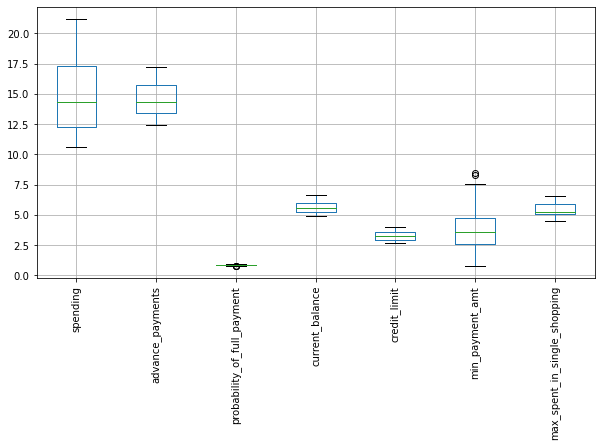

In [9]:
plt.figure(figsize=(10,5))
df1.boxplot(vert=1)
plt.xticks(rotation=90)

Very small number of outliers are present, which we can replace with upper limit

In [10]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [11]:
df1.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

In [12]:
l1,u1=remove_outlier(df1['probability_of_full_payment'])
df1['probability_of_full_payment']=np.where(df1['probability_of_full_payment']>u1,u1,df1['probability_of_full_payment'])
df1['probability_of_full_payment']=np.where(df1['probability_of_full_payment']<l1,l1,df1['probability_of_full_payment'])

l2,u2=remove_outlier(df1['min_payment_amt'])
df1['min_payment_amt']=np.where(df1['min_payment_amt']>u2,u2,df1['min_payment_amt'])
df1['min_payment_amt']=np.where(df1['min_payment_amt']<l2,l2,df1['min_payment_amt'])

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

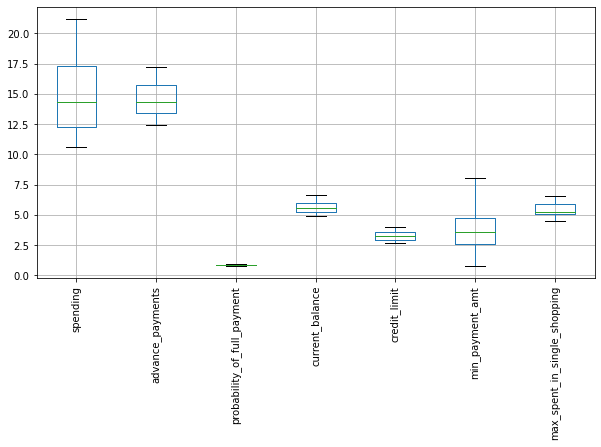

In [13]:
plt.figure(figsize=(10,5))
df1.boxplot(vert=1)
plt.xticks(rotation=90)

### Checking pairwise distribution of the continuous variables

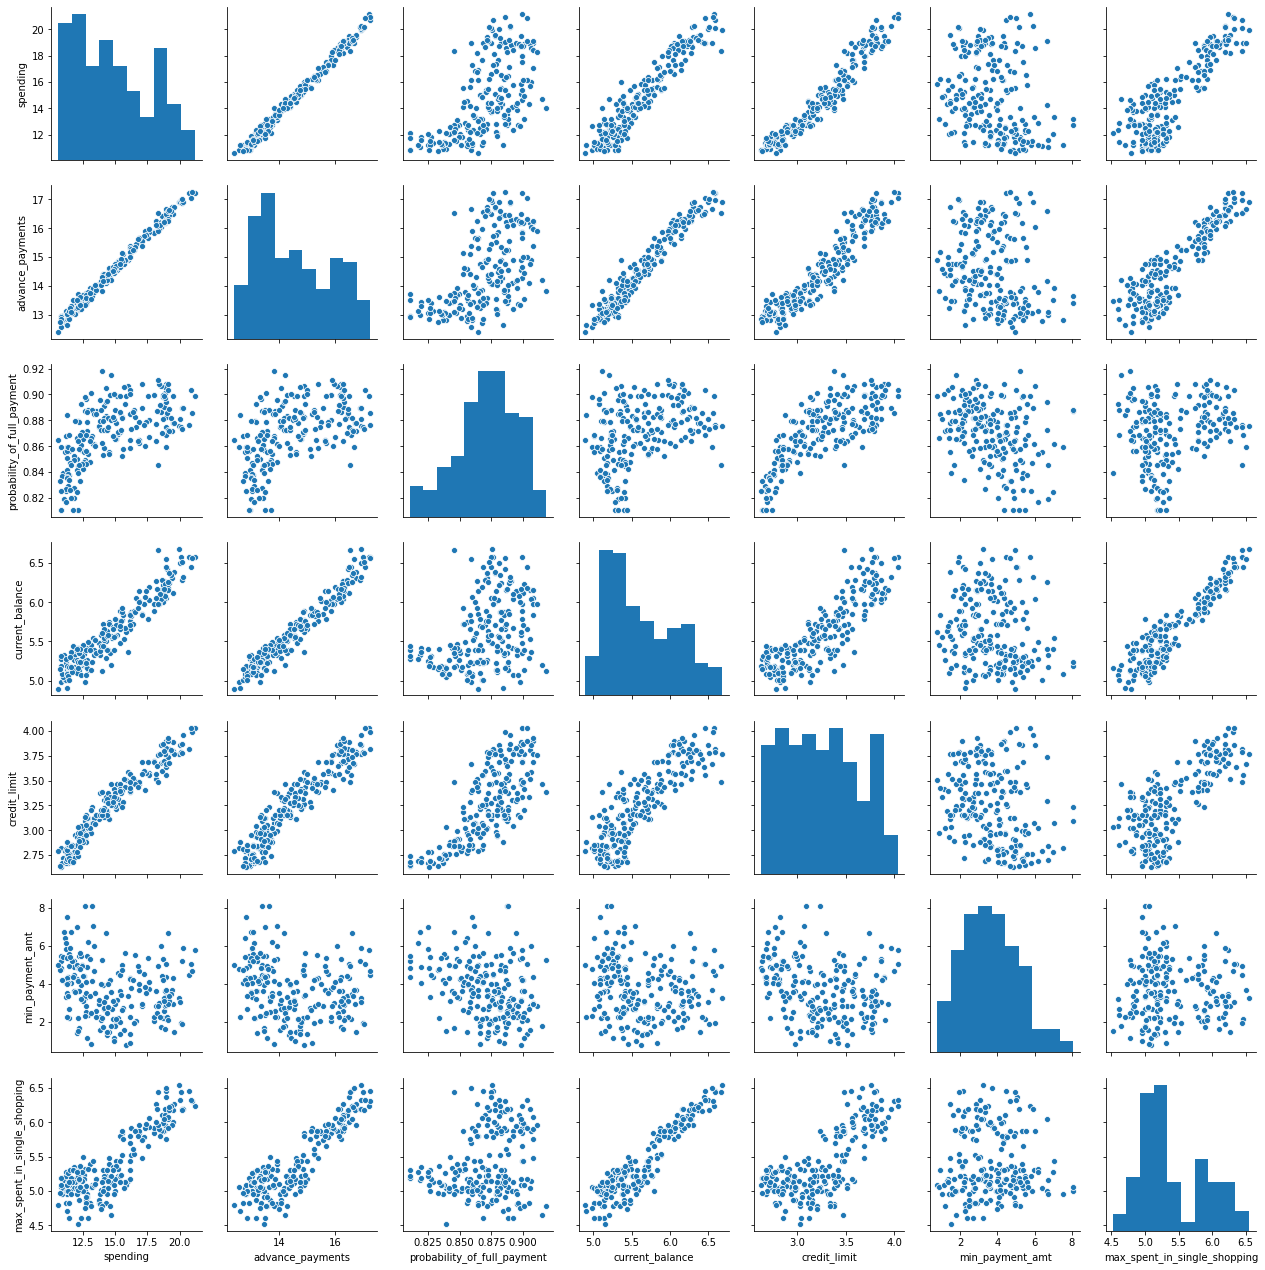

In [14]:
import seaborn as sns
sns.pairplot(df1)

Checking for Correlations¶

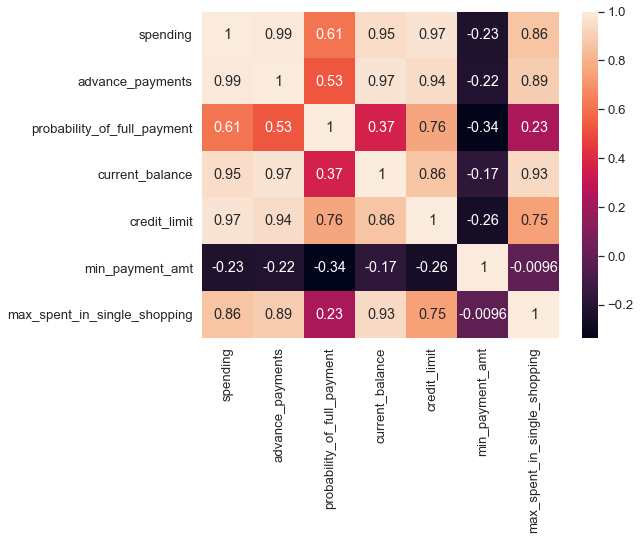

In [15]:
# construct heatmap with only continuous variables
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(df1.corr(), annot=True)

There is a high postive correlation among many variables such as 'spending', 'advance_payments', 'current_balance' and 'credit_limit'.

In [16]:
link_method = linkage(df1.iloc[:,:], method = 'average')

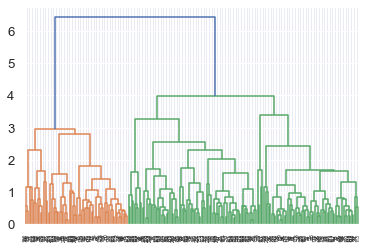

In [17]:
dend = dendrogram(link_method,
                 truncate_mode='lastp',
                 p = 210,
                 )

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
X = StandardScaler()

In [20]:
scaled_df1 = X.fit_transform(df1)

In [21]:
scaled_df1

array([[ 1.75435461,  1.81196782,  0.177628  , ...,  1.33857863,
        -0.29862524,  2.3289982 ],
       [ 0.39358228,  0.25383997,  1.50507052, ...,  0.85823561,
        -0.24229198, -0.53858174],
       [ 1.41330028,  1.42819249,  0.505234  , ...,  1.317348  ,
        -0.22083168,  1.50910692],
       ...,
       [-0.2816364 , -0.30647202,  0.36483143, ..., -0.15287318,
        -1.32804867, -0.83023461],
       [ 0.43836719,  0.33827054,  1.23277462, ...,  0.60081421,
        -0.95718798,  0.07123789],
       [ 0.24889256,  0.45340314, -0.77966228, ..., -0.07325831,
        -0.70905334,  0.96047321]])

In [22]:
scaled_df1 = pd.DataFrame(scaled_df1, index=df1.index, columns=df1.columns)
scaled_df1.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,1.754355,1.811968,0.177628,2.367533,1.338579,-0.298625,2.328998
1,0.393582,0.253840,1.505071,-0.600744,0.858236,-0.242292,-0.538582
2,1.413300,1.428192,0.505234,1.401485,1.317348,-0.220832,1.509107
3,-1.384034,-1.227533,-2.571391,-0.793049,-1.639017,0.995699,-0.454961
4,1.082581,0.998364,1.198738,0.591544,1.155464,-1.092656,0.874813


In [23]:
wss =[]

In [24]:
for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(scaled_df1)
    wss.append(KM.inertia_)

In [25]:
wss

[1469.9999999999998,
 659.1474009548498,
 430.298481751223,
 370.69092922102,
 325.97130311102984,
 289.41049428690263,
 263.11161842730417,
 242.41729887718694,
 223.26787867764014,
 208.40956895396818]

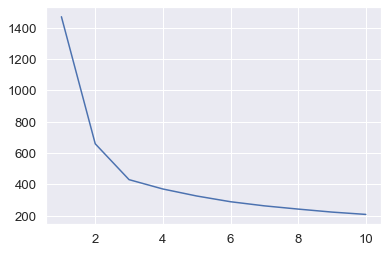

In [26]:
plt.plot(range(1,11), wss)

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [28]:
k_means = KMeans(n_clusters = 2, random_state=1)
k_means.fit(scaled_df1)
labels = k_means.labels_
labels

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])

check with 2 clusters.

In [29]:
silhouette_score(scaled_df1,labels)

0.46560100442748986

In [30]:
silhouette_samples(scaled_df1,labels).min()

-0.0056773797277176906

check with 3 clusters.

In [31]:
k_means3 = KMeans(n_clusters = 3,random_state=1)
k_means3.fit(scaled_df1)
labels_3 = k_means3.labels_
labels_3

array([0, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0,
       1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 0,
       0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2,
       0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 0,
       2, 2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2,
       2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1, 2, 0, 0, 0,
       2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1,
       0, 1, 2, 0, 2, 1, 0, 2, 0, 2, 2, 2])

In [32]:
silhouette_score(scaled_df1,labels_3)

0.4008059221522216

silhouette score is better for 2 clusters than for 3 clusters. So, final clusters will be 2

we will be going with 2 clusters. This is based on the Silhouette Score and Silhouette width.

In [33]:
sil_width = silhouette_samples(scaled_df1,labels_3)

In [34]:
df1["sil_width"] = sil_width
df1.head(5)

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,sil_width
0,19.94,16.92,0.875200,6.675,3.763,3.252,6.550,0.573278
1,15.99,14.89,0.906400,5.363,3.582,3.336,5.144,0.365564
2,18.95,16.42,0.882900,6.248,3.755,3.368,6.148,0.637092
3,10.83,12.96,0.810588,5.278,2.641,5.182,5.185,0.515595
4,17.99,15.86,0.899200,5.890,3.694,2.068,5.837,0.360972


In [35]:
df1['Kmeans_clusters'] = labels

In [36]:
df1.head(10)

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,sil_width,Kmeans_clusters
0,19.94,16.92,0.875200,6.675,3.763,3.252000,6.550,0.573278,1
1,15.99,14.89,0.906400,5.363,3.582,3.336000,5.144,0.365564,0
2,18.95,16.42,0.882900,6.248,3.755,3.368000,6.148,0.637092,1
3,10.83,12.96,0.810588,5.278,2.641,5.182000,5.185,0.515595,0
4,17.99,15.86,0.899200,5.890,3.694,2.068000,5.837,0.360972,1
5,12.70,13.41,0.887400,5.183,3.091,8.079625,5.000,0.221525,0
6,12.02,13.33,0.850300,5.350,2.810,4.271000,5.308,0.475295,0
7,13.74,14.05,0.874400,5.482,3.114,2.932000,4.825,0.360258,0
8,18.17,16.26,0.863700,6.271,3.512,2.853000,6.273,0.519383,1
9,11.23,12.88,0.851100,5.140,2.795,4.325000,5.003,0.534439,0


In [37]:
df1.to_csv('project1Cluster.csv')

In [38]:
df1[df1['Kmeans_clusters'] == 0].head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,sil_width,Kmeans_clusters
1,15.99,14.89,0.906400,5.363,3.582,3.336000,5.144,0.365564,0
3,10.83,12.96,0.810588,5.278,2.641,5.182000,5.185,0.515595,0
5,12.70,13.41,0.887400,5.183,3.091,8.079625,5.000,0.221525,0
6,12.02,13.33,0.850300,5.350,2.810,4.271000,5.308,0.475295,0
7,13.74,14.05,0.874400,5.482,3.114,2.932000,4.825,0.360258,0


In [39]:
df1[df1['Kmeans_clusters'] == 1].head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,sil_width,Kmeans_clusters
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,0.573278,1
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,0.637092,1
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,0.360972,1
8,18.17,16.26,0.8637,6.271,3.512,2.853,6.273,0.519383,1
10,18.55,16.22,0.8865,6.153,3.674,1.738,5.894,0.465994,1


Cluster_0 has a lower spending with lesser current_balance, low value of advanced_payments and low value of max_spent_in_single_shopping

Cluster_1 has higher spending with higher current_balance, high value of advanced_payments and high value of max_spent_in_single_shopping

# Problem Statement 2
An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.


## Importing all required Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Loading the Data

In [41]:
df2 = pd.read_csv("insurance_part2_data.csv")

## Checking the data

In [42]:
df2.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [43]:
df2.Claimed.value_counts(normalize = True)*100

No     69.2
Yes    30.8
Name: Claimed, dtype: float64

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


## Check for missing value in any column

In [45]:
# Are there any missing values ?
df2.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

## Summary of the data

In [46]:
df2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,3000,NaN,NaN,NaN,38.091,10.4635,8,32,36,42,84
Agency_Code,3000,4,EPX,1365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,3000,2,Travel Agency,1837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Claimed,3000,2,No,2076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Commision,3000,NaN,NaN,NaN,14.5292,25.4815,0,0,4.63,17.235,210.21
Channel,3000,2,Online,2954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,3000,NaN,NaN,NaN,70.0013,134.053,-1,11,26.5,63,4580
Sales,3000,NaN,NaN,NaN,60.2499,70.734,0,20,33,69,539
Product Name,3000,5,Customised Plan,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,3000,3,ASIA,2465,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Geting unique counts of all Nominal Variables

In [47]:
df2.columns

Index(['Age', 'Agency_Code', 'Type', 'Claimed', 'Commision', 'Channel',
       'Duration', 'Sales', 'Product Name', 'Destination'],
      dtype='object')

In [48]:
for column in df2[['Agency_Code', 'Claimed', 'Channel', 'Type', 'Product Name', 'Destination' ]]:
    print(column.upper(),': ',df2[column].nunique())
    print(df2[column].value_counts().sort_values())
    print('\n')

AGENCY_CODE :  4
JZI     239
CWT     472
C2B     924
EPX    1365
Name: Agency_Code, dtype: int64


CLAIMED :  2
Yes     924
No     2076
Name: Claimed, dtype: int64


CHANNEL :  2
Offline      46
Online     2954
Name: Channel, dtype: int64


TYPE :  2
Airlines         1163
Travel Agency    1837
Name: Type, dtype: int64


PRODUCT NAME :  5
Gold Plan             109
Silver Plan           427
Bronze Plan           650
Cancellation Plan     678
Customised Plan      1136
Name: Product Name, dtype: int64


DESTINATION :  3
EUROPE       215
Americas     320
ASIA        2465
Name: Destination, dtype: int64




In [49]:
print('Shape: ',df2.shape)

Shape:  (3000, 10)


## Check for duplicate data

In [50]:
# Are there any duplicates ?
dups = df2.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df2[dups]

Number of duplicate rows = 139


,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,C2B,Airlines,Yes,15.00,Online,27,60.00,Bronze Plan,ASIA
329,36,EPX,Travel Agency,No,0.00,Online,5,20.00,Customised Plan,ASIA
407,36,EPX,Travel Agency,No,0.00,Online,11,19.00,Cancellation Plan,ASIA
411,35,EPX,Travel Agency,No,0.00,Online,2,20.00,Customised Plan,ASIA
422,36,EPX,Travel Agency,No,0.00,Online,5,20.00,Customised Plan,ASIA
473,36,EPX,Travel Agency,No,0.00,Online,26,24.00,Customised Plan,ASIA
524,36,EPX,Travel Agency,No,0.00,Online,3,10.00,Cancellation Plan,ASIA
540,33,C2B,Airlines,Yes,54.00,Online,365,216.00,Silver Plan,ASIA
567,36,EPX,Travel Agency,No,0.00,Online,19,20.00,Customised Plan,ASIA
569,36,EPX,Travel Agency,No,0.00,Online,14,20.00,Customised Plan,ASIA


## Removing Duplicates

In [51]:
df2.drop_duplicates(inplace=True) 

In [52]:
dups = df2.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(df2.shape)

Number of duplicate rows = 0
(2861, 10)


Removing rows having 0 and -1 from 'Duration' column

In [53]:
df2.drop(df2[df2.Duration==0].index, inplace=True)

In [54]:
df2.drop(df2[df2.Duration==-1].index, inplace=True)

In [55]:
print(df2.shape)

(2858, 10)


In [56]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2858 non-null   int64  
 1   Agency_Code   2858 non-null   object 
 2   Type          2858 non-null   object 
 3   Claimed       2858 non-null   object 
 4   Commision     2858 non-null   float64
 5   Channel       2858 non-null   object 
 6   Duration      2858 non-null   int64  
 7   Sales         2858 non-null   float64
 8   Product Name  2858 non-null   object 
 9   Destination   2858 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 245.6+ KB


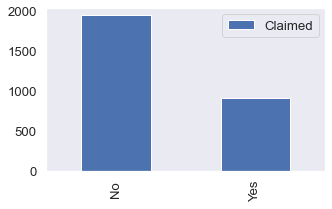

In [57]:
plt.figure(figsize=(5,3))
df2['Claimed'].value_counts().plot(kind='bar')
plt.legend()
plt.grid()
plt.show()

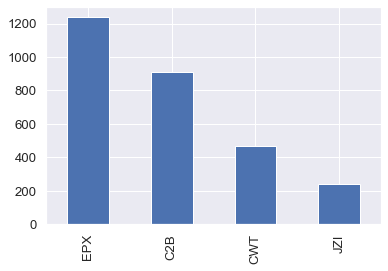

In [58]:
df2['Agency_Code'].value_counts().plot(kind='bar')

In [59]:
df2.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


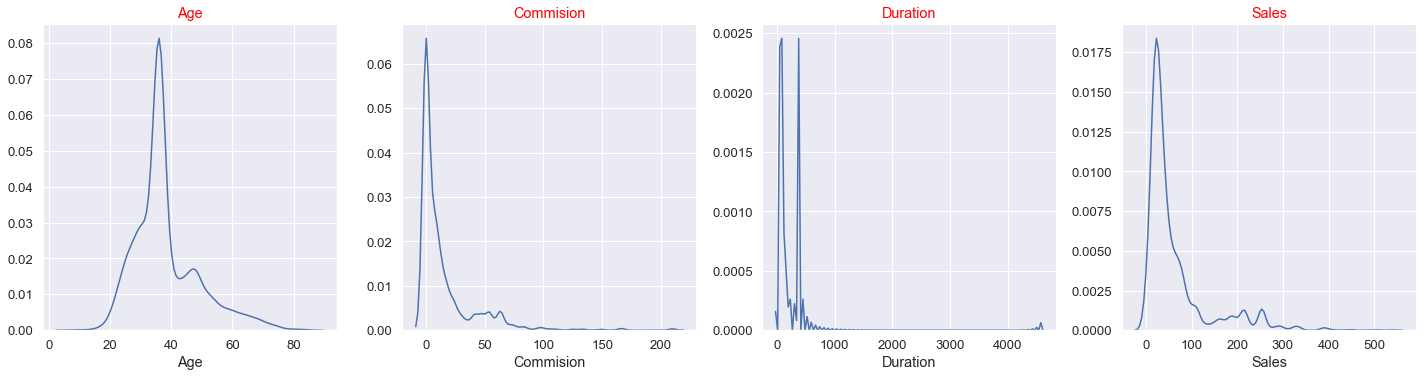

In [60]:
data_plot=df2[['Age', 'Commision', 'Duration', 'Sales',]]
fig=plt.figure(figsize=(20,20))
for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(4,4,i+1)
    sns.distplot(data_plot[data_plot.columns[i]],hist=False)
    ax.set_title(data_plot.columns[i],color='Red')
plt.tight_layout()
plt.show()

## Checking pairwise distribution of the continuous variables

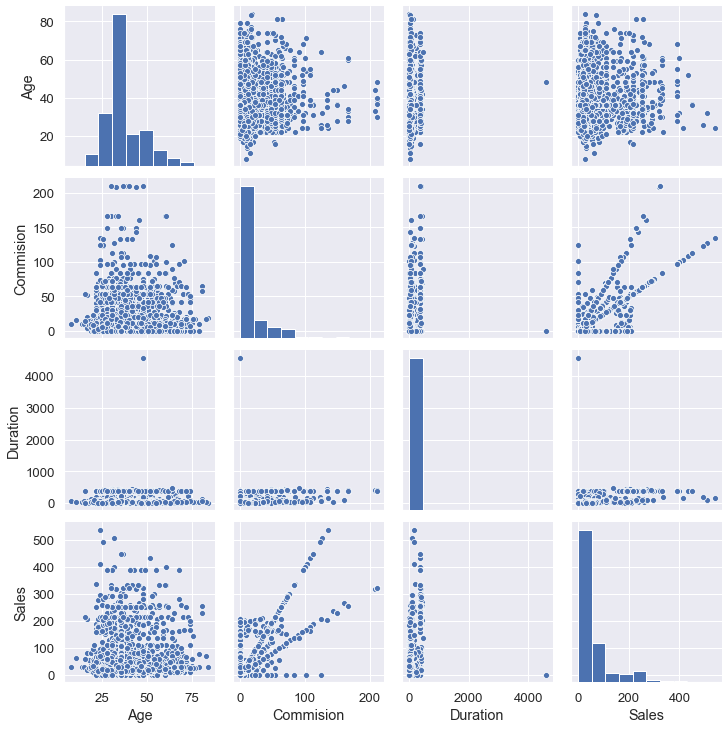

In [61]:
sns.pairplot(df2[['Age', 'Commision', 'Duration', 'Sales',]])

## Checking for Correlations

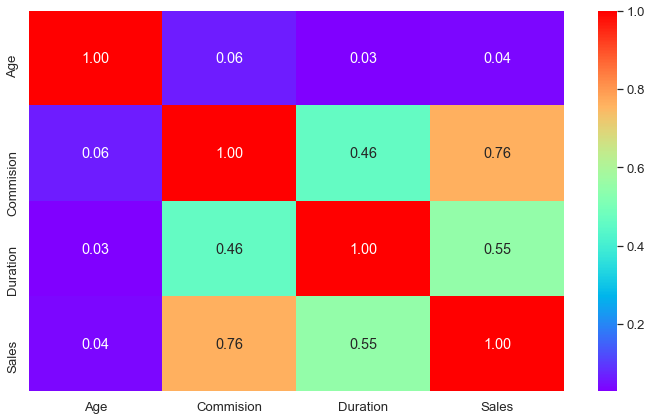

In [62]:
plt.figure(figsize=(12,7))
sns.heatmap(df2[['Age', 'Commision', 'Duration', 'Sales',]].corr(),annot=True,fmt='.2f',cmap='rainbow')
plt.show()

There are all positive correlations between variables, and no negative correlations.  Commission and sales have a high positive correaltion
Overall the magnitude of correlations between the variables are very less.

# Checking for outliers

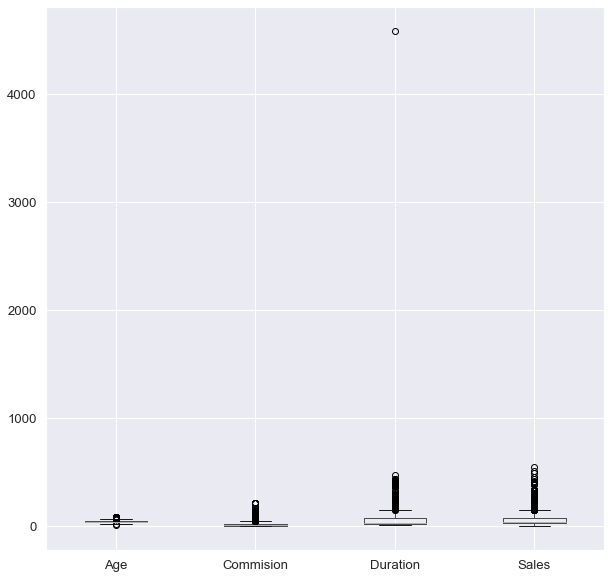

In [63]:
# construct box plot for continuous variables
plt.figure(figsize=(10,10))
df2[['Age', 'Commision', 'Duration', 'Sales',]].boxplot(vert=1)

There are outliers in all 4 numerical variables. Random Forest and ANN can handle the outliers. 
However, Outliers are treated for now, by replacing it with upper/lower values.

In [64]:
l1,u1=remove_outlier(df2['Age'])
df2['Age']=np.where(df2['Age']>u1,u1,df2['Age'])
df2['Age']=np.where(df2['Age']<l1,l1,df2['Age'])

In [65]:
l1,u1=remove_outlier(df2['Commision'])
df2['Commision']=np.where(df2['Commision']>u1,u1,df2['Commision'])
df2['Commision']=np.where(df2['Commision']<l1,l1,df2['Commision'])

In [66]:
l1,u1=remove_outlier(df2['Duration'])
df2['Duration']=np.where(df2['Duration']>u1,u1,df2['Duration'])
df2['Duration']=np.where(df2['Duration']<l1,l1,df2['Duration'])

In [67]:
l1,u1=remove_outlier(df2['Sales'])
df2['Sales']=np.where(df2['Sales']>u1,u1,df2['Sales'])
df2['Sales']=np.where(df2['Sales']<l1,l1,df2['Sales'])

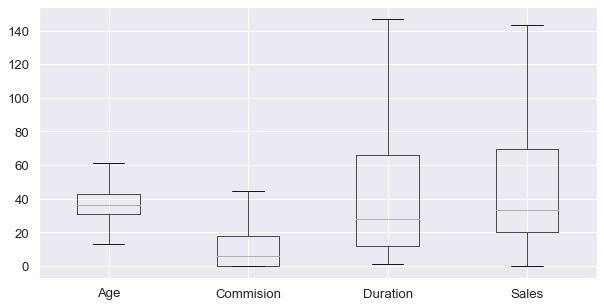

In [68]:
plt.figure(figsize=(10,5))
df2[['Age', 'Commision', 'Duration', 'Sales',]].boxplot(vert=1)

## Converting all objects to categorical codes

In [69]:
df2c = df2
for feature in df2c.columns: 
    if df2c[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df2c[feature].unique()))
        print(pd.Categorical(df2c[feature].unique()).codes)
        df2c[feature] = pd.Categorical(df2c[feature]).codes



feature: Agency_Code
[C2B, EPX, CWT, JZI]
Categories (4, object): [C2B, CWT, EPX, JZI]
[0 2 1 3]


feature: Type
[Airlines, Travel Agency]
Categories (2, object): [Airlines, Travel Agency]
[0 1]


feature: Claimed
[No, Yes]
Categories (2, object): [No, Yes]
[0 1]


feature: Channel
[Online, Offline]
Categories (2, object): [Offline, Online]
[1 0]


feature: Product Name
[Customised Plan, Cancellation Plan, Bronze Plan, Silver Plan, Gold Plan]
Categories (5, object): [Bronze Plan, Cancellation Plan, Customised Plan, Gold Plan, Silver Plan]
[2 1 0 4 3]


feature: Destination
[ASIA, Americas, EUROPE]
Categories (3, object): [ASIA, Americas, EUROPE]
[0 1 2]


## Proportion of 1s and 0s

In [70]:
df2c.Claimed.value_counts(normalize=True)

0    0.680196
1    0.319804
Name: Claimed, dtype: float64

There is no issue of class imbalance here as we have reasonable proportions in both the classes

## Extracting the target column into separate vectors for training set and test set

In [71]:
X = df2c.drop("Claimed" , axis=1)

y = df2c.pop("Claimed")

X.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48.0,0,0,0.70,1,7.0,2.51,2,0
1,36.0,2,1,0.00,1,34.0,20.00,2,0
2,39.0,1,1,5.94,1,3.0,9.90,2,1
3,36.0,2,1,0.00,1,4.0,26.00,1,0
4,33.0,3,0,6.30,1,53.0,18.00,0,0


## Splitting data into training and test set

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)

In [73]:
train_labels.value_counts(normalize=True)*100

0    67.25
1    32.75
Name: Claimed, dtype: float64

In [74]:
test_labels.value_counts(normalize=True)*100

0    69.81352
1    30.18648
Name: Claimed, dtype: float64

0    67.25
1    32.75
Name: Claimed, dtype: float64


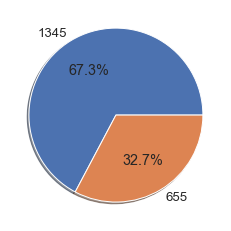

In [75]:
plt.pie(train_labels.value_counts(), labels=train_labels.value_counts().values, autopct='%1.1f%%', shadow=True);
print(train_labels.value_counts(normalize=True)*100)

0    69.81352
1    30.18648
Name: Claimed, dtype: float64


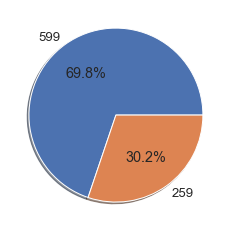

In [76]:
plt.pie(test_labels.value_counts(), labels=test_labels.value_counts().values, autopct='%1.1f%%', shadow=True);
print(test_labels.value_counts(normalize=True)*100)

Since the distribution of values of target variable is verified and found close to equal, it can be concluded that the data set is properly split

## Checking the dimensions of the training and test data

In [77]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

X_train (2000, 9)
X_test (858, 9)
train_labels (2000,)
test_labels (858,)


# Building a Decision Tree Classifier

In [78]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [20,25],
    'min_samples_split': [40,50]
}

dtcl = DecisionTreeClassifier(random_state=1)

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 5)

In [79]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 40}


In [80]:
best_grid = grid_search.best_estimator_
best_grid

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=40,
                       random_state=1)

In [81]:
#dtcl.fit(X_train,train_labels)
from sklearn import tree

train_char_label = ['No', 'Yes']
tree_regularized = open('Claimed_TreeReg_File.dot','w')
dot_data = tree.export_graphviz(best_grid, out_file= tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

tree_regularized.close()
dot_data

## Variable Importance

In [82]:
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.595163
Sales         0.242283
Product Name  0.082964
Commision     0.049578
Destination   0.013126
Age           0.009048
Duration      0.007838
Type          0.000000
Channel       0.000000


## Predicting on Training and Test dataset

In [83]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

## Getting the Predicted Classes and Probs

In [84]:
ytest_predict
ytest_predict_prob=best_grid.predict_proba(X_test)
ytest_predict_prob
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.725301,0.274699
1,0.409266,0.590734
2,0.922432,0.077568
3,0.725301,0.274699
4,0.210084,0.789916


## Model Evaluation

### AUC and ROC for the training data

AUC: 0.812


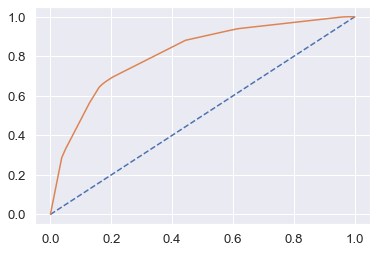

In [85]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr)

### AUC and ROC for the test data

AUC: 0.807


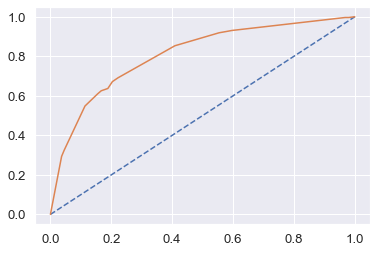

In [86]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, cart_testthresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr)

### Confusion Matrix for the training data

In [87]:
confusion_matrix(train_labels, ytrain_predict)

array([[1130,  215],
       [ 234,  421]], dtype=int64)

In [88]:
#Train Data Accuracy
cart_train_acc=best_grid.score(X_train,train_labels) 
cart_train_acc

0.7755

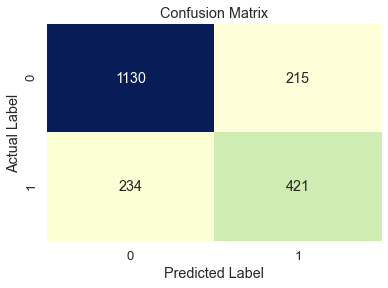

In [89]:
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [90]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1345
           1       0.66      0.64      0.65       655

    accuracy                           0.78      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.77      0.78      0.77      2000



In [91]:
cart_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_train_f1=round(df.loc["1"][2],2)
cart_train_recall=round(df.loc["1"][1],2)
cart_train_precision=round(df.loc["1"][0],2)
print ('cart_train_precision ',cart_train_precision*100,'%')
print ('cart_train_recall ',cart_train_recall*100,'%')
print ('cart_train_f1 ',cart_train_f1*100,'%')

cart_train_precision  66.0 %
cart_train_recall  64.0 %
cart_train_f1  65.0 %


### Confusion Matrix for test data

In [92]:
confusion_matrix(test_labels, ytest_predict)

array([[506,  93],
       [101, 158]], dtype=int64)

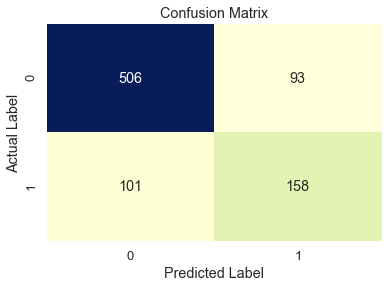

In [93]:
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [94]:
#Test Data Accuracy
cart_test_acc=best_grid.score(X_test,test_labels)
cart_test_acc

0.7738927738927739

In [95]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       599
           1       0.63      0.61      0.62       259

    accuracy                           0.77       858
   macro avg       0.73      0.73      0.73       858
weighted avg       0.77      0.77      0.77       858



In [96]:
cart_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_test_precision=round(df.loc["1"][0],2)
cart_test_recall=round(df.loc["1"][1],2)
cart_test_f1=round(df.loc["1"][2],2)
print ('cart_test_precision ',cart_test_precision*100,'%')
print ('cart_test_recall ',cart_test_recall*100,'%')
print ('cart_test_f1 ',cart_test_f1*100,'%')

cart_test_precision  63.0 %
cart_test_recall  61.0 %
cart_test_f1  62.0 %


http://webgraphviz.com/

# Building a Random Forest Classifier

### Grid Search for finding out the optimal values for the hyper parameters

In [97]:
param_grid = {
    'max_depth': [4,5,7],
    'max_features': [4,5,6],
    'min_samples_leaf': [2,3],
    'min_samples_split': [25,30,35],
    'n_estimators': [30,40,50]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5)

In [ ]:
grid_search.fit(X_train, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
best_grid

## Predicting the Training and Testing data

In [ ]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

## RF Model Performance Evaluation on Training data

In [ ]:
confusion_matrix(train_labels,ytrain_predict)

In [ ]:
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
rf_train_acc=best_grid.score(X_train,train_labels) 
rf_train_acc

In [ ]:
print(classification_report(train_labels,ytrain_predict))

In [ ]:
rf_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_train_precision=round(df.loc["1"][0],2)
rf_train_recall=round(df.loc["1"][1],2)
rf_train_f1=round(df.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision*100,'%')
print ('rf_train_recall ',rf_train_recall*100,'%')
print ('rf_train_f1 ',rf_train_f1*100,'%')

In [ ]:
rf_train_fpr, rf_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(rf_train_fpr,rf_train_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_train_auc=roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1])
print('Area under Curve is', rf_train_auc)

## RF Model Performance Evaluation on Test data

In [ ]:
confusion_matrix(test_labels,ytest_predict)

In [ ]:
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
rf_test_acc=best_grid.score(X_test,test_labels)
rf_test_acc

In [ ]:
print(classification_report(test_labels,ytest_predict))

In [ ]:
rf_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(df.loc["1"][0],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_f1=round(df.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision*100,'%')
print ('rf_test_recall ',rf_test_recall*100,'%')
print ('rf_test_f1 ',rf_test_f1*100,'%')

In [ ]:
rf_test_fpr, rf_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(rf_test_fpr,rf_test_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_test_auc=roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1])
print('Area under Curve is', rf_test_auc)

In [ ]:
# Variable Importance
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

# Building a Neural Network Classifier

In [ ]:
param_grid = {
    'hidden_layer_sizes': [50,100,200], # 50, 200
    'max_iter': [500,1000], #5000,2500
    'solver': ['adam', 'sgd'], #sgd
    'tol': [0.01], 
}

nncl = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 10, verbose=True)

In [ ]:
grid_search.fit(X_train, train_labels)
grid_search.best_params_
#{'hidden_layer_sizes': 100, 'max_iter': 2500, 'solver': 'adam', 'tol': 0.01}

In [ ]:
best_grid = grid_search.best_estimator_
best_grid

In [ ]:
nncl = MLPClassifier(hidden_layer_sizes=200, max_iter=500,
                     solver='adam', verbose=True,  random_state=1,tol=0.01)


In [ ]:
nncl.fit(X_train,train_labels)
ytestpred = nncl.predict(X_test)

## Predicting the Training and Testing data

In [ ]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [ ]:
nncl.fit(X_train,train_labels)
ytestpred = nncl.predict(X_test)

## NN Model Performance Evaluation on Training data

In [ ]:
confusion_matrix(train_labels,ytrain_predict)

In [ ]:
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
nn_train_acc=best_grid.score(X_train,train_labels) 
nn_train_acc

In [ ]:
print(classification_report(train_labels,ytrain_predict))

In [ ]:
nn_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_train_precision=round(df.loc["1"][0],2)
nn_train_recall=round(df.loc["1"][1],2)
nn_train_f1=round(df.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

In [ ]:
nn_train_fpr, nn_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(nn_train_fpr,nn_train_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_train_auc=roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1])
print('Area under Curve is', nn_train_auc)

## NN Model Performance Evaluation on Test data

In [ ]:
confusion_matrix(test_labels,ytest_predict)

In [ ]:
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
nn_test_acc=best_grid.score(X_test,test_labels)
nn_test_acc

In [ ]:
print(classification_report(test_labels,ytest_predict))

In [ ]:
nn_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_test_precision=round(df.loc["1"][0],2)
nn_test_recall=round(df.loc["1"][1],2)
nn_test_f1=round(df.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

In [ ]:
nn_test_fpr, nn_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(nn_test_fpr,nn_test_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_test_auc=roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1])
print('Area under Curve is', nn_test_auc)

In [ ]:
best_grid.score

# Final Conclusion

## Comparison of the performance metrics from the 3 models

In [ ]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[nn_train_acc,nn_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[nn_test_acc,nn_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

## ROC Curve for the 3 models on the Training data

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(nn_train_fpr,nn_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

## ROC Curve for the 3 models on the Test data

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(nn_test_fpr,nn_test_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

Out of the 3 models, Random Forest has slightly better performance than the Cart and Neural network model

Overall all the 3 models are reasonaly stable enough to be used for making any future predictions.
From Cart and Random Forest Model, the variable Agency_Code is found to be the most useful feature amongst all other features for predicting claim status. 